# Import Necessary Libraries

In [3]:
!pip install nltk
!pip install textblob
!pip install wordcloud

from warnings import filterwarnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("vader_lexicon")

filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
pd.set_option("display.float_format", lambda x: '%.2f' % x)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Import Dataset

In [4]:
df = pd.read_csv("/content/amazon_review.csv", sep=",")
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.00,best deal around,1373673600,2013-07-13,513,0,0


# Text Processing

In [5]:
def text_preprocessing(dataframe, dependent_var):
  # Normalizing Case Folding - Uppercase to Lowercase
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x.lower() for x in str(x).split()))

  # Removing Punctuation
  dataframe[dependent_var] = dataframe[dependent_var].str.replace('[^\w\s]','')

  # Removing Numbers
  dataframe[dependent_var] = dataframe[dependent_var].str.replace('\d','')

  # StopWords
  sw = stopwords.words('english')
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

  # Remove Rare Words
  temp_df = pd.Series(' '.join(dataframe[dependent_var]).split()).value_counts()
  drops = temp_df[temp_df <= 1]
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x for x in str(x).split() if x not in drops))

  # Lemmatize
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

  return dataframe

In [6]:
df = text_preprocessing(df, "reviewText")

In [7]:
df["reviewText"].head()

0                                                issue
1    purchased device worked advertised never much ...
2    work expected higher capacity think made bit e...
3    think worked gb card went south one held prett...
4    bought retail packaging arrived legit envelope...
Name: reviewText, dtype: object

# Text Visualization

In [8]:
def text_visulaization(dataframe, dependent_var, barplot=True, wordcloud=True):
  # Calculation of Term Frequencies
  tf = dataframe[dependent_var].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
  tf.columns = ["words", "tf"]

  if barplot:
    # Bar Plot
    tf[tf["tf"]>1000].plot.barh(x="words", y="tf")
    plt.title("Calculation of Term Frequencies : barplot")
    plt.show()

  if wordcloud:
    # WordCloud
    text = " ".join(i for i in dataframe[dependent_var])
    wordcloud = WordCloud(max_font_size=100, max_words=1000, background_color="white").generate(text)
    plt.figure(figsize=[10, 10])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Calculation of Term Frequencies : wordcloud")
    plt.show()
    wordcloud.to_file("wordcloud.png")


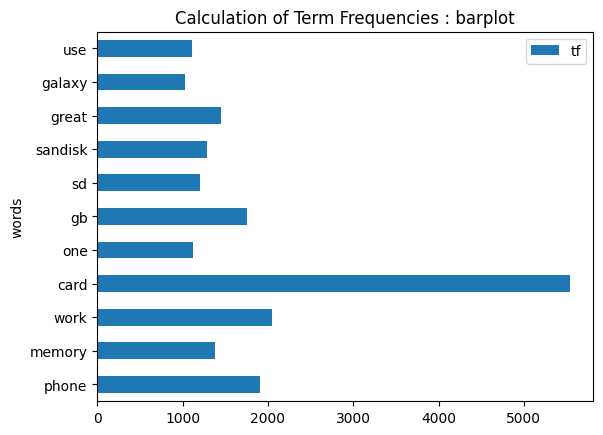

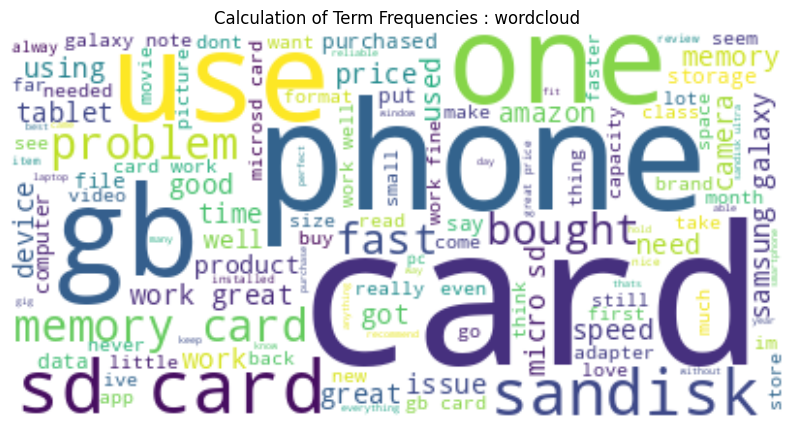

In [9]:
text_visulaization(df, "reviewText")

# Sentiment Analysis

In [10]:
def create_polarity_scores(dataframe, dependent_var):
  sia = SentimentIntensityAnalyzer()
  dataframe["polarity_score"] = dataframe[dependent_var].apply(lambda x: sia.polarity_scores(x)["compound"])

In [11]:
create_polarity_scores(df, "reviewText")

In [12]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,polarity_score
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",issue,4.00,Four Stars,1406073600,2014-07-23,138,0,0,0.00
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]",purchased device worked advertised never much ...,5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,0.00
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",work expected higher capacity think made bit e...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0,0.40
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",think worked gb card went south one held prett...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,0.65
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]",bought retail packaging arrived legit envelope...,5.00,best deal around,1373673600,2013-07-13,513,0,0,0.86


# Feature Engineering

In [13]:
# Create Lables
def create_label(dataframe, dependent_var, independent_var):
  sia = SentimentIntensityAnalyzer()
  dataframe[independent_var] = dataframe[dependent_var].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
  dataframe[independent_var] = LabelEncoder().fit_transform(dataframe[independent_var])

  X = dataframe[dependent_var]
  y = dataframe[independent_var]

  return X, y

In [14]:
X, y = create_label(df, "reviewText", "sentiment_label")

In [15]:
# Split Dataset
def split_dataset(dataframe, X, y):
  train_x, test_x, train_y, test_y = train_test_split(X, y, random_state=1)
  return train_x, test_x, train_y, test_y

In [16]:
train_x, test_x, train_y, test_y = split_dataset(df, X, y)

In [17]:
def create_features_count(train_x, test_x):
  # Count Vectors
  vectorizer = CountVectorizer()
  x_train_count_vectorizer = vectorizer.fit_transform(train_x)
  x_test_count_vectorizer = vectorizer.fit_transform(test_x)

  return x_train_count_vectorizer, x_test_count_vectorizer

In [18]:
x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)

In [19]:
def create_features_TFIDF_word(train_x, test_x):
  # TF-IDF word
  tf_idf_word_vectorizer = TfidfVectorizer()
  x_train_tf_idf_word = tf_idf_word_vectorizer.fit_transform(train_x)
  x_test_tf_idf_word = tf_idf_word_vectorizer.fit_transform(test_x)

  return x_train_tf_idf_word, x_test_tf_idf_word

In [20]:
x_train_tf_idf_word, x_test_tf_idf_word = create_features_TFIDF_word(train_x, test_x)

In [21]:
def create_features_TFIDF_ngram(train_x, test_x):
  # TF-IDF ngram
  tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2,3))
  x_train_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(train_x)
  x_test_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(test_x)

  return x_train_tf_idf_ngram, x_test_tf_idf_ngram

In [22]:
x_train_tf_idf_ngram, x_test_tf_idf_ngram = create_features_TFIDF_ngram(train_x, test_x)

In [23]:
def create_features_TFIDF_chars(train_x, test_x):
  # TF-IDF Characters
  tf_idf_chars_vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(2,3))
  x_train_tf_idf_chars = tf_idf_chars_vectorizer.fit_transform(train_x)
  x_test_tf_idf_chars = tf_idf_chars_vectorizer.fit_transform(test_x)

  return x_train_tf_idf_chars, x_test_tf_idf_chars

In [24]:
x_train_tf_idf_chars, x_test_tf_idf_chars = create_features_TFIDF_chars(train_x, test_x)

# Sentiment Modeling - Create Model

In [25]:
# Logistic Regression
def crate_model_logistic(train_x, test_x):
  # Count
  x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)
  loj_count = LogisticRegression(solver='lbfgs', max_iter=1000)
  loj_model_count = loj_count.fit(x_train_count_vectorizer, train_y)
  accuracy_count = cross_val_score(loj_model_count, x_test_count_vectorizer, test_y, cv=10).mean()
  print("Accuracy - Count Vectors: %.3f" % accuracy_count)

  # TF-IDF Word
  x_train_tf_idf_word, x_test_tf_idf_word = create_features_TFIDF_word(train_x, test_x)
  loj_word = LogisticRegression(solver='lbfgs', max_iter=1000)
  loj_model_word = loj_word.fit(x_train_tf_idf_word, train_y)
  accuracy_word = cross_val_score(loj_model_word, x_test_tf_idf_word, test_y, cv=10).mean()
  print("Accuracy - TF-IDF Word: %.3f" % accuracy_word)

  # TF-IDF ngram
  x_train_tf_idf_ngram, x_test_tf_idf_ngram = create_features_TFIDF_ngram(train_x, test_x)
  loj_ngram = LogisticRegression(solver='lbfgs', max_iter=1000)
  loj_model_ngram = loj_ngram.fit(x_train_tf_idf_ngram, train_y)
  accuracy_ngram = cross_val_score(loj_model_ngram, x_test_tf_idf_ngram, test_y, cv=10).mean()
  print("Accuracy TF-IDF ngram: %.3f" % accuracy_ngram)

  # TF-IDF chars

  loj_chars = LogisticRegression(solver='lbfgs', max_iter=1000)
  loj_model_chars = loj_chars.fit(x_train_tf_idf_chars, train_y)
  accuracy_chars = cross_val_score(loj_model_chars, x_test_tf_idf_chars, test_y, cv=10).mean()
  print("Accuracy TF-IDF Characters: %.3f" % accuracy_chars)

  return loj_model_count, loj_model_word, loj_model_ngram, loj_model_chars

In [26]:
loj_model_count, loj_model_word, loj_model_ngram, loj_model_chars = crate_model_logistic(train_x, test_x)

Accuracy - Count Vectors: 0.832
Accuracy - TF-IDF Word: 0.801
Accuracy TF-IDF ngram: 0.802
Accuracy TF-IDF Characters: 0.803


In [27]:
# Random Forest
def crate_model_randomforest(train_x, test_x):
  # Count
  x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)
  rf_count = RandomForestClassifier()
  rf_model_count = rf_count.fit(x_train_count_vectorizer, train_y)
  accuracy_count = cross_val_score(rf_model_count, x_test_count_vectorizer, test_y, cv=10).mean()
  print("Accuracy - Count Vectors: %.3f" % accuracy_count)

  # TF-IDF Word
  x_train_tf_idf_word, x_test_tf_idf_word = create_features_TFIDF_word(train_x, test_x)
  rf_word = RandomForestClassifier()
  rf_model_word = rf_word.fit(x_train_tf_idf_word, train_y)
  accuracy_word = cross_val_score(rf_model_word, x_test_tf_idf_word, test_y, cv=10).mean()
  print("Accuracy - TF-IDF Word: %.3f" % accuracy_word)

  # TF-IDF ngram
  x_train_tf_idf_ngram, x_test_tf_idf_ngram = create_features_TFIDF_ngram(train_x, test_x)
  rf_ngram = RandomForestClassifier()
  rf_model_ngram = rf_ngram.fit(x_train_tf_idf_ngram, train_y)
  accuracy_ngram = cross_val_score(rf_model_ngram, x_test_tf_idf_ngram, test_y, cv=10).mean()
  print("Accuracy TF-IDF ngram: %.3f" % accuracy_ngram)

  # TF-IDF chars

  rf_chars = RandomForestClassifier()
  rf_model_chars = rf_chars.fit(x_train_tf_idf_chars, train_y)
  accuracy_chars = cross_val_score(rf_model_chars, x_test_tf_idf_chars, test_y, cv=10).mean()
  print("Accuracy TF-IDF Characters: %.3f" % accuracy_chars)

  return rf_model_count, rf_model_word, rf_model_ngram, rf_model_chars

In [28]:
rf_model_count, rf_model_word, rf_model_ngram, rf_model_chars = crate_model_randomforest(train_x, test_x)

Accuracy - Count Vectors: 0.808
Accuracy - TF-IDF Word: 0.801
Accuracy TF-IDF ngram: 0.747
Accuracy TF-IDF Characters: 0.803


# Model Tuning

In [29]:
def model_tuning_randomforest(train_x, test_x):
  # Count
  x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)
  rf_model_count = RandomForestClassifier(random_state=1)
  rf_params = {"max_depth": [2,5,8, None],
               "max_features": [2,5,8, "auto"],
               "n_estimators": [100,500,1000],
               "min_samples_split": [2,5,10]}
  rf_best_grid = GridSearchCV(rf_model_count, rf_params, cv=10, n_jobs=-1, verbose=False).fit(x_train_count_vectorizer, train_y)
  rf_model_count_final = rf_model_count.set_params(**rf_best_grid.best_params_, random_state=1).fit(x_train_count_vectorizer, train_y)
  accuracy_count = cross_val_score(rf_model_count_final, x_test_count_vectorizer, test_y, cv=10).mean()
  print("Accuracy - Count Vectors: %.3f" % accuracy_count)

  return rf_model_count_final

In [30]:
rf_model_count_final = model_tuning_randomforest(train_x, test_x)

Accuracy - Count Vectors: 0.812


# Prediction

In [31]:
def predict_count(train_x, model, new_comment):
  new_comment= pd.Series(new_comment)
  new_comment = CountVectorizer().fit(train_x).transform(new_comment)
  result = model.predict(new_comment)
  if result==1:
    print("Comment is Positive")
  else:
    print("Comment is Negative")

In [32]:
# Logistic Regression
predict_count(train_x, model=loj_model_count, new_comment="this product is very good :)")

Comment is Positive


In [36]:
# Logistic Regression
predict_count(train_x, model=loj_model_count, new_comment="this product is superb :)")

Comment is Positive


In [33]:
# Random Forest
predict_count(train_x, model=rf_model_count, new_comment="this product is very bad :)")

Comment is Negative


In [37]:
# Random Forest
predict_count(train_x, model=rf_model_count, new_comment="this product is worst :)")

Comment is Positive


In [34]:
# Sample Review
new_comment=pd.Series(df["reviewText"].sample(1).values)
new_comment

0    work fairly fast definitely mb fast copying vi...
dtype: object

In [35]:
# Sample Review - Random Forest
predict_count(train_x, model=rf_model_count, new_comment=new_comment)

Comment is Positive
